In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from pathlib import Path
import pandas as pd

In [16]:
PROCESSED_DATA_DIR = Path("data/processing_checkpoint")
checkpoint_file_path = PROCESSED_DATA_DIR / "03_10_day_window_sliced.parquet"

In [17]:
df_final = pd.read_parquet(checkpoint_file_path)

In [18]:
final_numerical_features = [
    "count_about", "count_total_sessions", "count_downgrade", "count_error",
    "thumbs_ratio", "ads_per_session", "frequency", "avg_songs_session", 
    "errors_per_session", "user_lifecycle_h", "count_roll_advert", "count_upgrade",
    "session_length_variance", "active_days_ratio", "hours_since_last_session",
    "unique_songs_ratio", "hours_since_downgrade", "is_new_user",
    "within_window_activity_ratio", "song_listening_change",
    "recent_activity_ratio", "session_depth_change"
]

final_categorical_features = ["last_level"]

all_features = final_numerical_features + final_categorical_features

In [ ]:
X = df_final[all_features]
y = df_final["label"]

In [20]:
df_numerical_subset = X[final_numerical_features]

correlation_matrix = df_numerical_subset.corr()

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

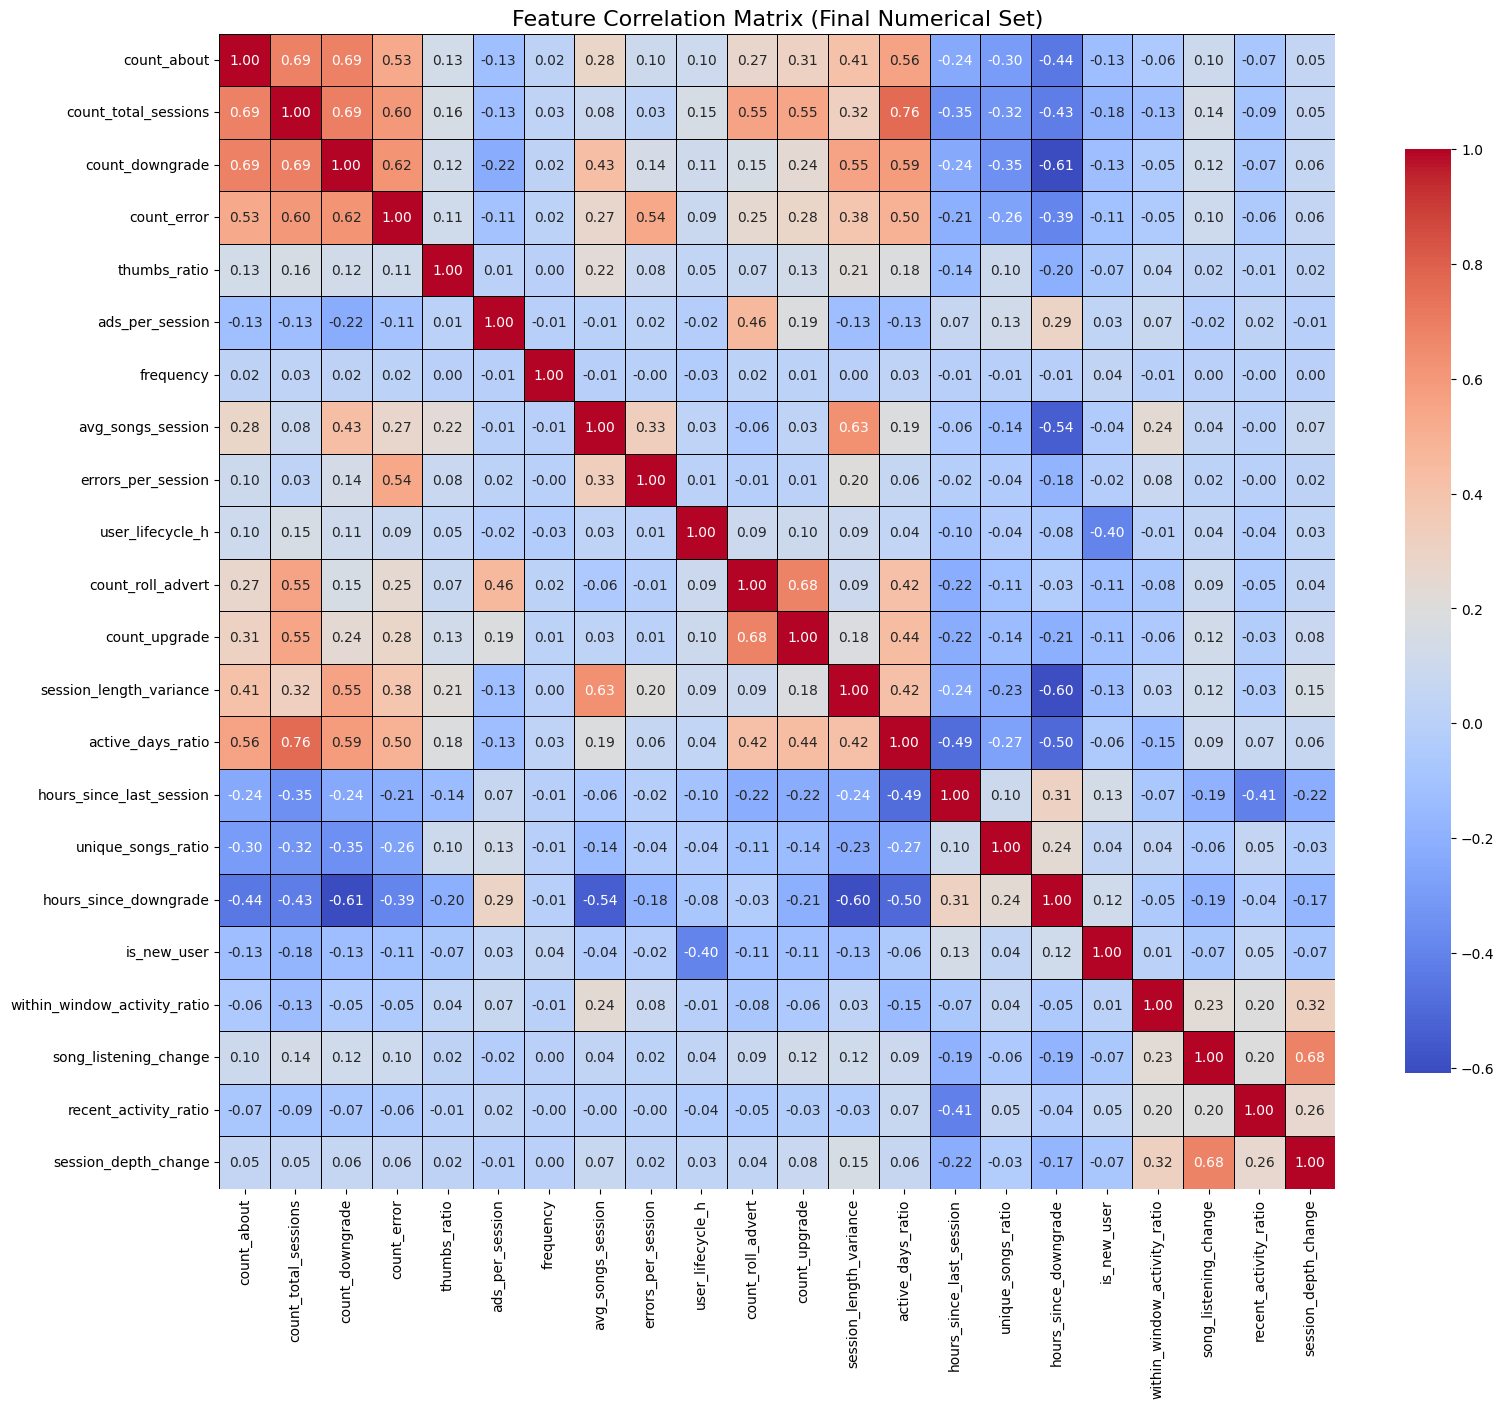

In [ ]:
plt.figure(figsize=(18, 15))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'shrink': 0.8}
)

plt.title('Feature Correlation Matrix (Final Numerical Set)', fontsize=16)
plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.ensemble import HistGradientBoostingClassifier

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), final_categorical_features),
        ("num", StandardScaler(), final_numerical_features)
    ],
    remainder="passthrough"
)

In [25]:
lr_model = LogisticRegression(solver="liblinear", penalty="l1", C=0.05)

In [26]:
gbdt_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ("classifier", lr_model)
])

In [27]:
tscv = TimeSeriesSplit(n_splits=5)
scoring = {'F1': make_scorer(f1_score), 'AUC': make_scorer(roc_auc_score)}

In [28]:
gbdt_scores = cross_validate(
    gbdt_pipeline, 
    X, 
    y, 
    scoring=scoring, 
    cv=tscv, 
    n_jobs=-1
)

In [29]:
print(f"GBDT Mean F1 Score (Validation): {gbdt_scores['test_F1'].mean():.4f}")
print(f"GBDT Mean AUC Score (Validation): {gbdt_scores['test_AUC'].mean():.4f}")

GBDT Mean F1 Score (Validation): 0.1714
GBDT Mean AUC Score (Validation): 0.6581
